In [2]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge



In [3]:
class MyLinearRegression:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept

    def fit(self, X, y):
        n, k = X.shape

        X_train = X
        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))

        self.w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y

        return self

    def predict(self, X):
        n, k = X.shape
        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))

        y_pred = X_train @ self.w

        return y_pred

    def get_weights(self):
        return self.w

In [4]:
from sklearn.model_selection import train_test_split

def linear_expression(x):
    return 5 * x + 6



In [5]:
# по признакам сгенерируем значения таргетов с некоторым шумом
objects_num = 50
X = np.linspace(-5, 5, objects_num)
y = linear_expression(X) + np.random.randn(objects_num) * 5

# выделим половину объектов на тест
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

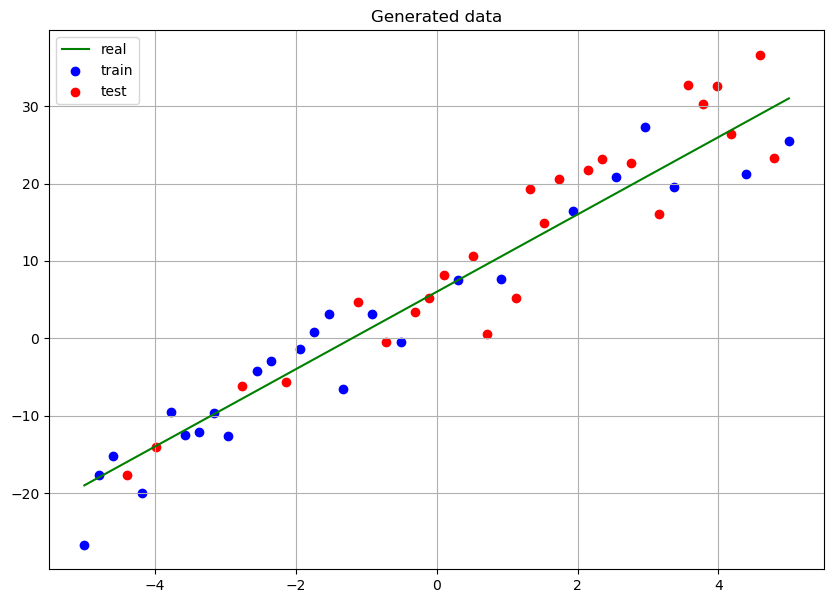

In [6]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label="real", c="g")
plt.scatter(X_train, y_train, label="train", c="b")
plt.scatter(X_test, y_test, label="test", c="red")


plt.title("Generated data")
plt.grid()
plt.legend()
plt.show()

In [7]:
regressor = MyLinearRegression()

regressor.fit(X_train[:, np.newaxis], y_train)

predictions = regressor.predict(X_test[:, np.newaxis])
w = regressor.get_weights()
w

array([4.87070268, 5.29876416])

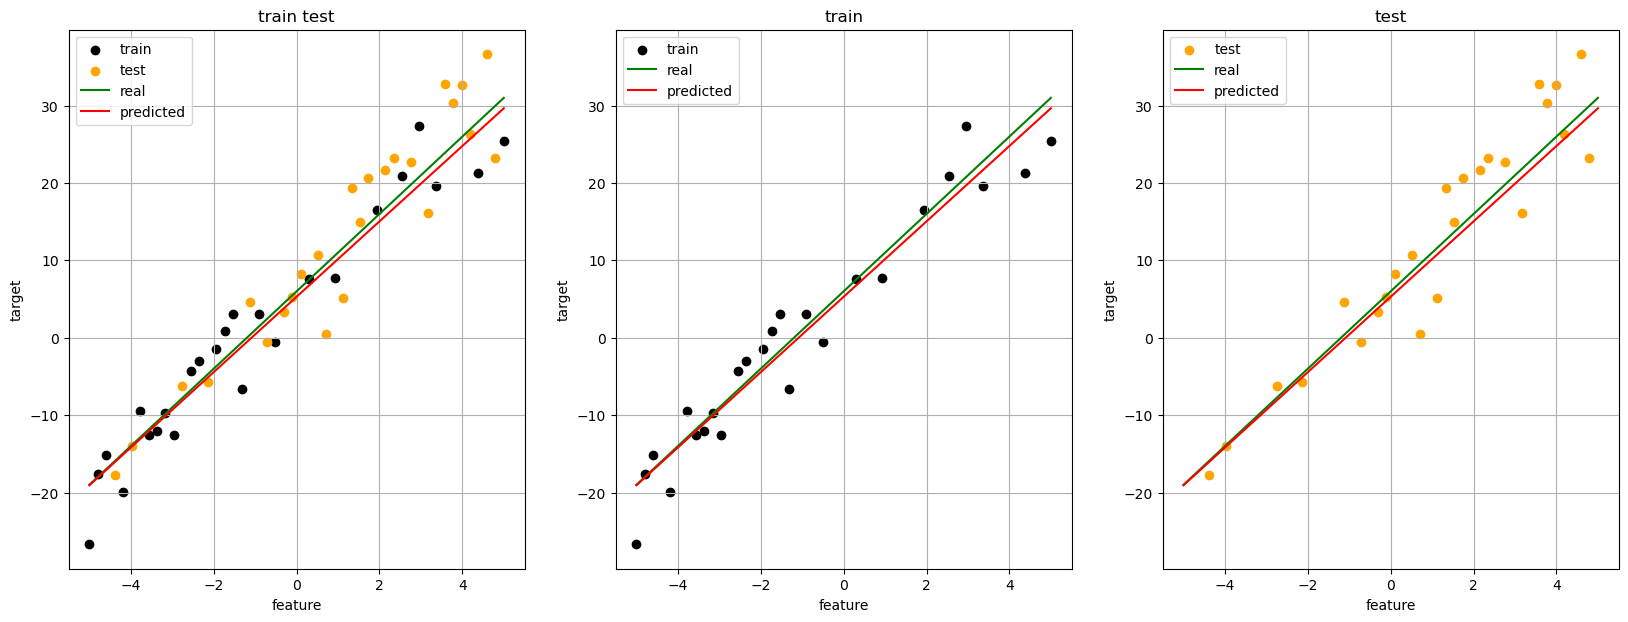

In [8]:
plt.figure(figsize=(20, 7))

ax = None

for i, types in enumerate([["train", "test"], ["train"], {"test"}]):
    ax = plt.subplot(1, 3, i + 1, sharey=ax)

    if "train" in types:
        plt.scatter(X_train, y_train, label="train", c="black")

    if "test" in types:
        plt.scatter(X_test, y_test, label="test", c="orange")

    plt.plot(X, linear_expression(X), label="real", color="green")
    plt.plot(X, regressor.predict(X[:, np.newaxis]), label="predicted", c="r")

    plt.ylabel("target")
    plt.xlabel("feature")
    plt.title(" ".join(types))
    plt.grid()
    plt.legend()

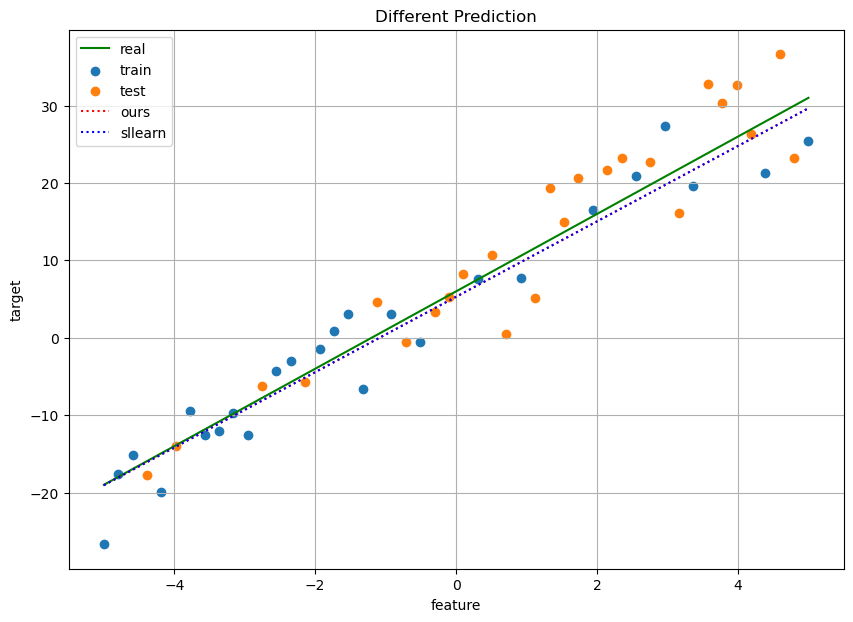

In [9]:
sk_regression = LinearRegression().fit(X_train[:, np.newaxis], y_train)

plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label="real", color="green")

plt.scatter(X_train, y_train, label="train")
plt.scatter(X_test, y_test, label="test")
plt.plot(X, regressor.predict(X[:, np.newaxis]), label="ours", color="red", linestyle=":")
plt.plot(X, sk_regression.predict(X[:, np.newaxis]), label="sllearn", c="blue", linestyle=":")

plt.title("Different Prediction")
plt.ylabel("target")
plt.xlabel("feature")
plt.grid()
plt.legend()
plt.show()

In [10]:
from sklearn.metrics import mean_squared_error

train_predictions = regressor.predict(X_train[:, np.newaxis])
test_predictions = regressor.predict(X_test[:, np.newaxis])

print("Train MSE: ", mean_squared_error(y_train, train_predictions))
print("Test MSE: ", mean_squared_error(y_test, test_predictions))

Train MSE:  14.17509865115399
Test MSE:  27.64189628935398


In [11]:
class MyGradientRegression(MyLinearRegression):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = None

    def fit(self, X, y, lr=0.01, max_iter=100):

        n, k = X.shape

        if self.w is None:
            self.w = np.random.randn(k+1 if self.fit_intercept else k)

        X_train = np.hstack((X, np.ones((n, 1)))) if self.fit_intercept else X

        self.losses = []

        for iter_num in range(max_iter):
            y_pred = self.predict(X)
            self.losses.append(mean_squared_error(y_pred, y))

            gradient = self._calc_gradient(X_train, y, y_pred)

            assert gradient.shape == self.w.shape, f"gradient shape {gradient.shape} is not equal weight shape {self.w.shape}"
            
            self.w -= lr * gradient

        return self
    
    def _calc_gradient(self, X, y, y_pred):
        gradient = 2 * (y_pred - y)[:, np.newaxis] * X
        gradient = gradient.mean(axis=0)
        return gradient
    
    def get_losses(self):
        return self.losses
        

In [12]:
regressor = MyGradientRegression(fit_intercept=True)

l = regressor.fit(X_train[:, np.newaxis], y_train, max_iter=100).get_losses()

predictions = regressor.predict(X_test[:, np.newaxis])
w = regressor.get_weights()
w



array([4.72544581, 4.0999028 ])

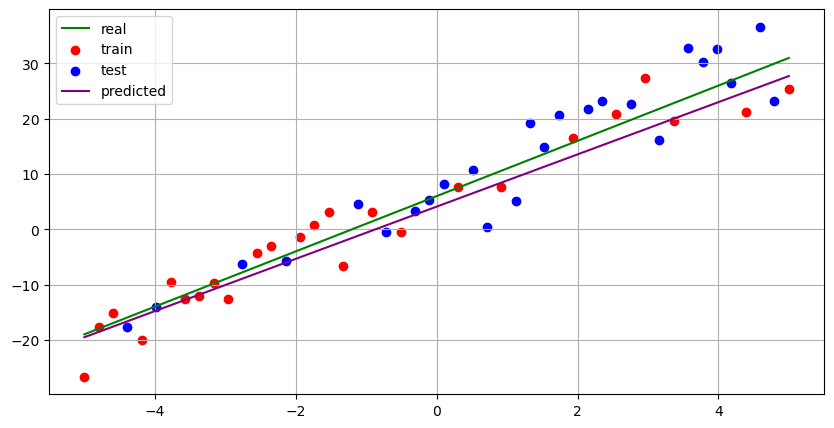

In [13]:
plt.figure(figsize=(10, 5))

plt.plot(X, linear_expression(X), label="real", c="g")

plt.scatter(X_train, y_train, label="train", c="red")
plt.scatter(X_test, y_test, label="test", c="blue")
plt.plot(X, regressor.predict(X[:, np.newaxis]), label="predicted", color="purple")

plt.grid()
plt.legend()
plt.show()

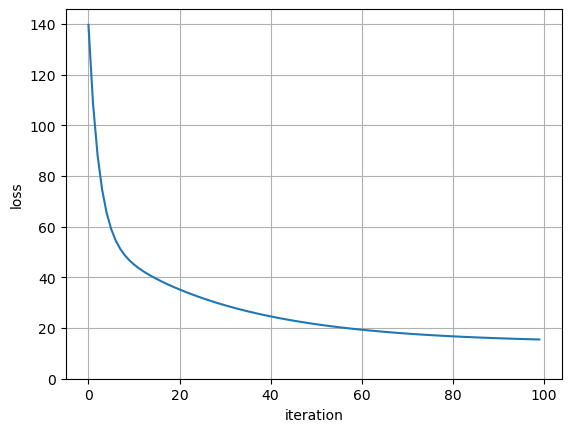

In [14]:
plt.plot(l)


plt.ylabel("loss")
plt.xlabel("iteration")
plt.ylim(bottom=0)
plt.grid(alpha=1)

plt.show()

GSD - сэмплирование мини-батча

In [15]:
class MyGSD(MyGradientRegression):
    def __init__(self, n_sample=10, **kwargs):
        super().__init__(**kwargs)
        self.w = None
        self.n_sample = n_sample

    def _calc_gradient(self, X, y, y_pred):
        inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)

        gradient = 2 * (y_pred[inds] - y[inds])[:, np.newaxis] * X[inds]
        gradient = gradient.mean(axis=0)

        return gradient

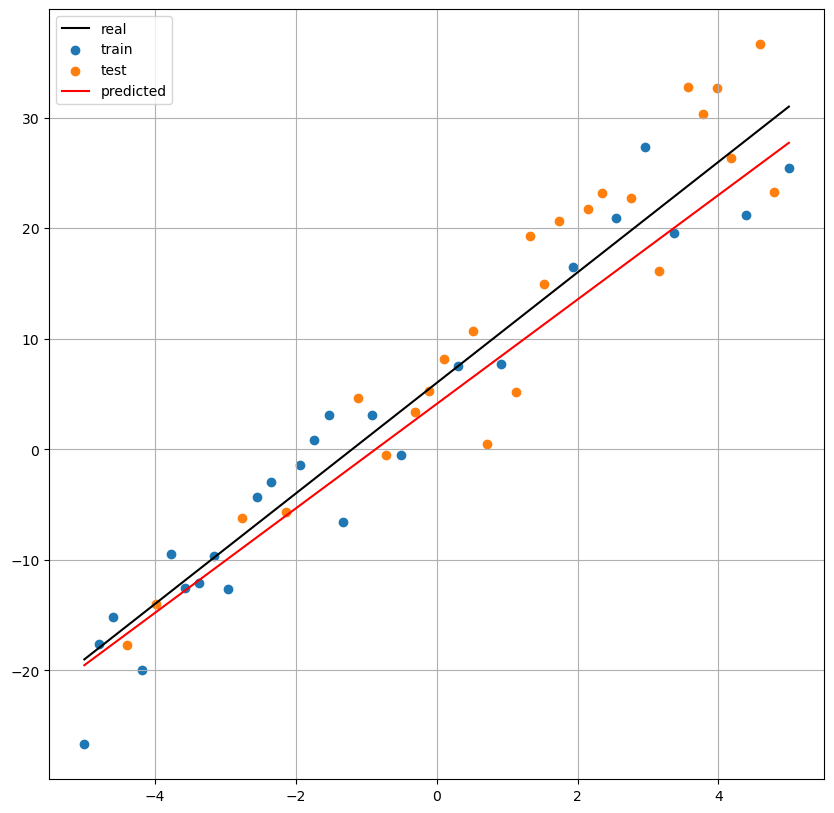

In [16]:
plt.figure(figsize=(10, 10))
plt.plot(X, linear_expression(X), label="real", color="black")

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label="test")
plt.plot(X, regressor.predict(X[:, np.newaxis]), label="predicted", c="red")

plt.grid(alpha=1)
plt.legend()
plt.show()

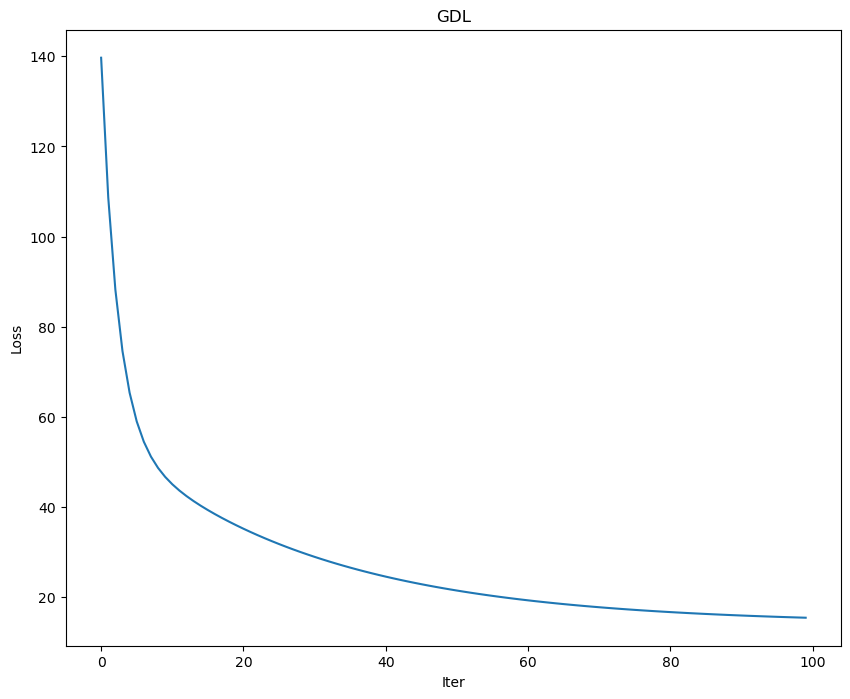

In [17]:
plt.figure(figsize=(10, 8))

plt.plot(l)

plt.title("GDL")
plt.ylabel("Loss")
plt.xlabel("Iter")
plt.show()

In [18]:
regressor = MyGSD(fit_intercept=True)

l = regressor.fit(X_train[:, np.newaxis], y_train, max_iter=100).get_losses()

predictions = regressor.predict(X_test[:, np.newaxis])
w = regressor.get_weights()


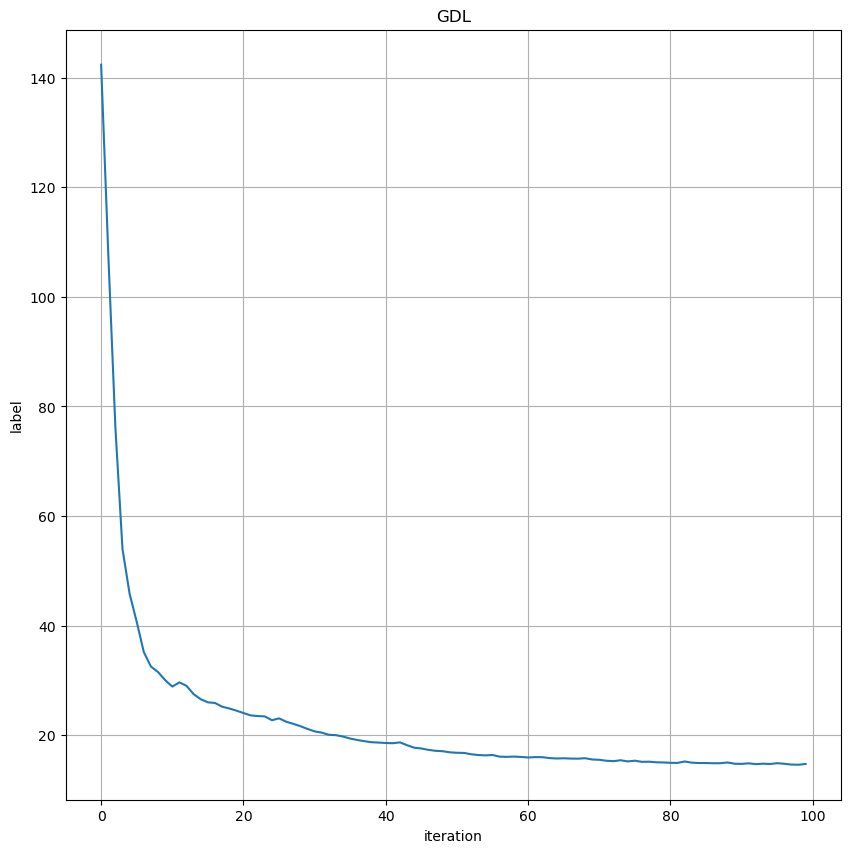

In [19]:
plt.figure(figsize=(10, 10))

plt.plot(l)

plt.title("GDL")
plt.ylabel("label")
plt.xlabel("iteration")
plt.grid()
plt.show()

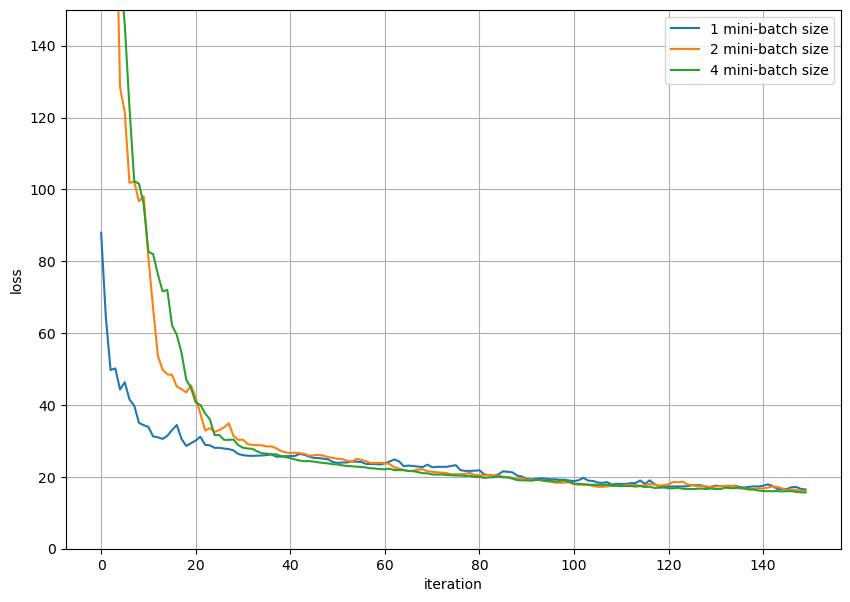

In [20]:
count_samples = [1, 2, 4]

plt.figure(figsize=(10, 7))

for sample in count_samples:
    regressor = MyGSD(fit_intercept=True, n_sample=sample)

    l= regressor.fit(X_train[:, np.newaxis], 
                     y_train, 
                     max_iter=150, 
                     lr=5e-3).get_losses()

    predictions = regressor.predict(X_test[:, np.newaxis])
    w = regressor.get_weights()

    plt.plot(l, alpha=1, label=f"{sample} mini-batch size")

plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.ylim((0, 150))
plt.grid()
plt.show()



Логистическая регрессия 

In [21]:
def logit(x, w):
    return np.dot(x, w)

def sigmoid(h):
    return 1. / (1 + np.exp(-h))

class MyLogisticRegression(object):
    def __init__(self):
        self.w = None

    def fit(self, X, y, max_iter=100, lr=0.1):
        n, k = X.shape
        if self.w is None:
            self.w = np.random.randn(k+1)

        X_train = np.concatenate((np.ones(n, 1), X), axis=1)

        losses = []

        for iter_num in range(max_iter):
            z = sigmoid(logit((X_train, self.w)))
            grad = np.dot(X_train.T, (z-y)) / len(y)

            self.w -= grad * lr

            losses.append(self.__loss(y, z))

        return losses
    
    def predict_proba(self, X):
        n, k = np.shape
        X_ = np.concatenate((np.ones((n, 1)), X), axis=1)
        return sigmoid(logit(X_, self.w))
    
    def predict(self, X, threshold=0.5):
        return self.w
    
    def __loss(self, y, p):
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return np.mean(y * np.log(p) + (1-y) + np.log(1-p))
    

    